### バンディット問題

##### 強化学習の枠組み

![](./picture/pict1.png)

強化学習ではエージェントと環境が相互にやりとりを行います<br>

**エージェント**<br>
行動する主体のこと、エージェントは、何らかの環境に置かれ、環境の「状態」を観測し、それに基づき「行動」を行います。強化学習の目標は、エージェントが得る報酬の総和を最大にする行動パターンを身につけることです。

**バンディット問題**<br>
確率論と機械学習において、一定の限られた資源のセットを競合する選択肢間で、期待利得を最大化するように配分しなければならない問題。それぞれの選択肢の特性が、配分時には一部しか分かっておらず、時間が経過したり選択肢に資源が配分されることで理解できる可能性がある。これは、探索(exploration)と活用(exploitation)のトレードオフのジレンマを例証する古典的な強化学習の問題である。（Wiki)

バンディット問題では、マシンの「価値」を知ることはできません。その状況の中で価値が最大になるスロットを選ぶことが求められます。つまり、実際にプレイをした上で、自分の選択が正しかったのかを推定する必要があり！

**標本平均で推定**<br>
![](./picture/pict2.png)

式変形を施し、Q(n-1)を代入すると、以下のようになる。

![](./picture/pict3.png)

ぞれぞれの項の位置関係は以下のようになる。

![](./picture/pict4.png)

Q(n-1)がQ(n)に更新される際はR(n)の方向へ進みますが、どれだけ更新するかが、1/nによって調整されます。（学習率）

In [5]:
import numpy as np

# incremental implementation
np.random.seed(0)
Q = 0

for n in range(1, 11):
    reward = np.random.rand()
    Q = Q + (reward - Q) / n #Q += (reward - Q) / n)　でもOK
    print(Q)

0.5488135039273248
0.6320014351498722
0.6222554154571294
0.6029123573420713
0.567060845741438
0.5801997236289743
0.5598265075766483
0.6013198192273272
0.6415801460355164
0.6157662833145425


では、各マシンの価値の推定値（平均値）が一番大きい値のマシンを選ぶことが、最適なのでしょうか。（greedyな戦略)

マシンAとマシンBを１回ずつプレイし、推定値がそれぞれ０と１だったとき、Aが良いマシンなのに、Bだけが選ばれ続けることになってしまい、良い戦略とは言えません。

つまり、スロットマシンの価値を精度よく推定するために、様々なスロットマシンを試すことが必要です。

**活用**；これまでの経験から最善の行動を選ぶこと（greedyな行動）<br>
**探索**；各スロットマシンの価値をより制度よく推定する（greeedyでない行動）<br>

これはトレードオフの関係にあり、「活用と探索のバランス」をいかにうまくとるか、これが強化学習のアルゴリズムの行き着く問題です。

#### ε-greedy法
εの確率（例えば１０％）で「探索」を行い、それ以外は、「活用」を行う手法

「探索」ではランダムに行動を選ぶことで、様々な行動をまんべんなく試す

#### バンディットアルゴリズムの実装

In [6]:
class Bandit:
    def __init__(self, arms=10):
        self.rates = np.random.rand(arms) # 0~1の乱数を生成し、各マシンの勝率を設定

    def play(self, arm):
        rate = self.rates[arm]
        if rate > np.random.rand(): # 勝率を超える乱数が出たら勝ち
            return 1
        else:
            return 0

１０回マシンを動かしてみる

In [8]:
bandit = Bandit()

for i in range(10):
    print(bandit.play(0))

0
0
0
1
0
0
1
1
0
0


#### エージェントの実装
まずは、０番目のスロットマシンだけに注目して、そのスロットマシンの価値の推定を行う。

In [9]:
bandit = Bandit()
Q = 0

for n in range(1, 11):
    reward = bandit.play(0)
    Q = Q + (reward - Q) / n
    print(Q)

1.0
1.0
0.6666666666666667
0.75
0.8
0.8333333333333334
0.7142857142857143
0.75
0.6666666666666666
0.7


0番目の推定値は0.7とわかった。

続けて、１０台のスロットマシンそれぞれの価値の推定値を求めてみます。

In [11]:
for n in range(10):
    action = np.random.randint(0,10)
    reward = bandit.play(action)

    ns[action] += 1
    Qs[action] += (reward - Qs[action]) / ns[action]
    print(Qs)

[0.  0.  1.  0.4 0.  0.  0.  0.  0.  0. ]
[0.  0.  1.  0.4 0.  0.  0.  0.  0.  0. ]
[0.  0.  1.  0.4 0.  0.  0.  0.  0.  0. ]
[0.         0.         1.         0.33333333 0.         0.
 0.         0.         0.         0.        ]
[1.         0.         1.         0.33333333 0.         0.
 0.         0.         0.         0.        ]
[1.         0.         1.         0.42857143 0.         0.
 0.         0.         0.         0.        ]
[1.         0.         1.         0.42857143 0.         0.
 0.         0.         0.         0.        ]
[1.    0.    1.    0.375 0.    0.    0.    0.    0.    0.   ]
[1.    0.    1.    0.375 0.    0.    0.    0.    0.    0.   ]
[1.    0.    1.    0.375 0.    0.    0.    0.    0.    0.   ]


Agentクラスの実装

In [13]:
class Agent:
    def __init__(self, epsilon, action_size=10):
        self.epsilon = epsilon
        self.Qs = np.zeros(action_size)
        self.ns = np.zeros(action_size)

    def update(self, action, reward):
        self.ns[action] += 1
        self.Qs[action] += (reward - self.Qs[action]) / self.ns[action]

    def get_action(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, len(self.Qs))
        return np.argmax(self.Qs)

準備が整ったので、１０００回マシンを動かして、どれだけの報酬が得られるか見てみる。

863


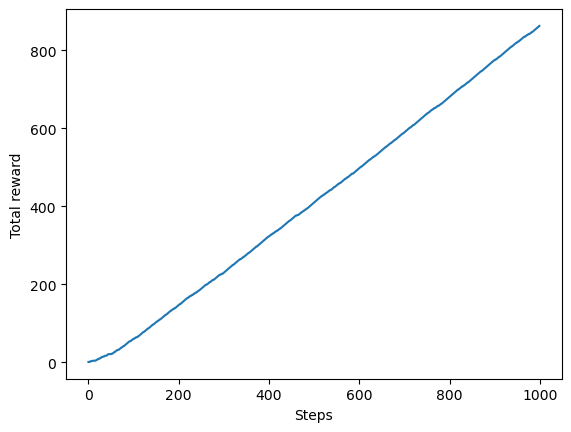

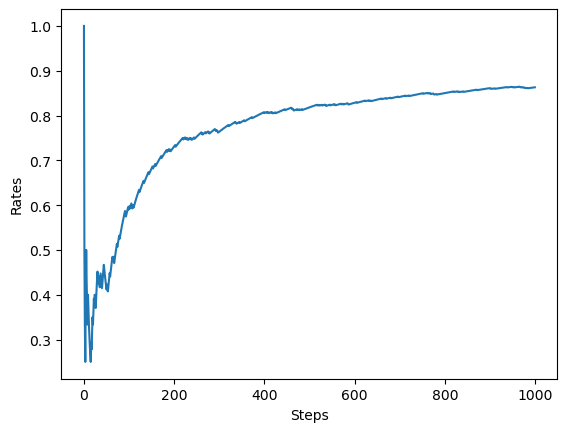

In [17]:
import matplotlib.pyplot as plt

steps = 1000
epsilon = 0.1

bandit = Bandit()
agent = Agent(epsilon)
total_reward = 0
total_rewards = []
rates = []

for step in range(steps):
    action = agent.get_action() # 行動を選択
    reward = bandit.play(action) # 報酬を得る
    agent.update(action, reward) # Q値を更新
    total_reward += reward

    total_rewards.append(total_reward)
    rates.append(total_reward / (step + 1))

print(total_reward)

plt.ylabel('Total reward')
plt.xlabel('Steps')
plt.plot(total_rewards)
plt.show()

plt.ylabel('Rates')
plt.xlabel('Steps')
plt.plot(rates)
plt.show()

849
772
794
867
878
924
881
883
883
750


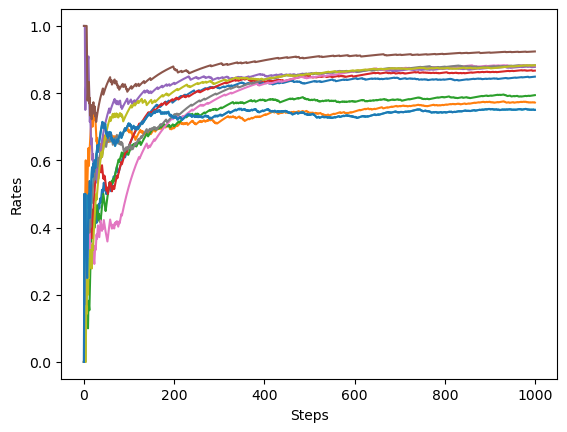

In [20]:
steps = 1000
epsilon = 0.1
experiments = 10

for experiment in range(experiments):
    bandit = Bandit()
    agent = Agent(epsilon)
    total_reward = 0
    total_rewards = []
    rates = []

    for step in range(steps):
        action = agent.get_action() # 行動を選択
        reward = bandit.play(action) # 報酬を得る
        agent.update(action, reward) # Q値を更新
        total_reward += reward

        total_rewards.append(total_reward)
        rates.append(total_reward / (step + 1))

    print(total_reward)

    # ratesをプロット
    plt.plot(rates, label=f'Experiment {experiment + 1}')
    
plt.ylabel('Rates')
plt.xlabel('Steps')
plt.plot(rates)
plt.show()

#### アルゴリズムの平均的な性質
ここでは、スロットマシンを１０００回プレイするという、これまでの実験を２００回行いその結果を平均します。

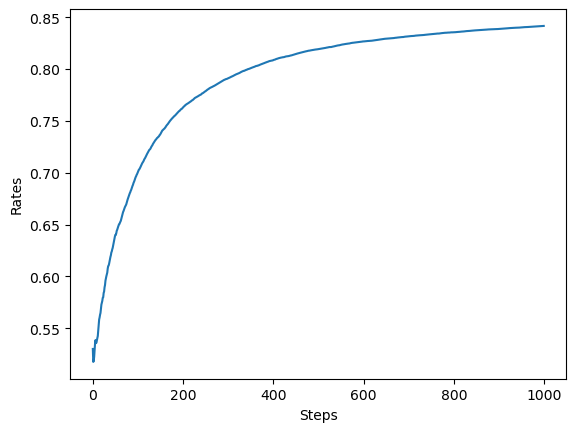

In [24]:
runs = 200
steps = 1000
epsilon = 0.1
all_rates = np.zeros((runs, steps))  # (200, 1000)

for run in range(runs):
    bandit = Bandit()
    agent = Agent(epsilon)
    total_reward = 0
    rates = []

    for step in range(steps):
        action = agent.get_action()
        reward = bandit.play(action)
        agent.update(action, reward)
        total_reward += reward
        rates.append(total_reward / (step + 1))

    all_rates[run] = rates

avg_rates = np.average(all_rates, axis=0)

plt.ylabel('Rates')
plt.xlabel('Steps')
plt.plot(avg_rates)
plt.show()

epsilonが異なる場合もやってみる。

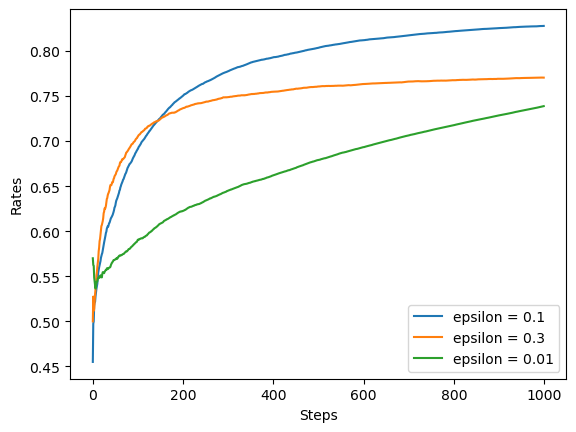

In [26]:
import numpy as np
import matplotlib.pyplot as plt

runs = 200
steps = 1000
epsilons = [0.1, 0.3, 0.01]  # 複数のepsilonの値

# グラフをプロットするための準備
plt.ylabel('Rates')
plt.xlabel('Steps')

# 複数のepsilonに対してシミュレーションを行う
for epsilon in epsilons:
    all_rates = np.zeros((runs, steps))  # (200, 1000)
    
    for run in range(runs):
        bandit = Bandit()  # バンディット問題のインスタンスを生成
        agent = Agent(epsilon)  # epsilonに応じたエージェントを生成
        total_reward = 0
        rates = []
        
        for step in range(steps):
            action = agent.get_action()
            reward = bandit.play(action)
            agent.update(action, reward)
            total_reward += reward
            rates.append(total_reward / (step + 1))
        
        all_rates[run] = rates

    avg_rates = np.average(all_rates, axis=0)  # 各runの平均を計算
    
    # epsilonの値に対応したグラフを描画
    plt.plot(avg_rates, label=f'epsilon = {epsilon}')

plt.legend()  # 凡例を追加
plt.show()  # グラフを表示


ステップ数も変えてみる

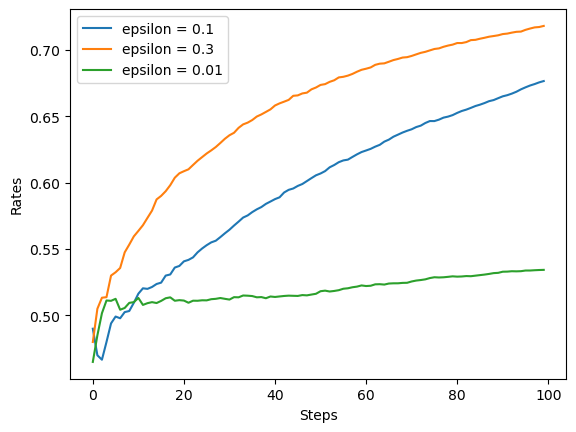

In [28]:
runs = 200
steps = 100
epsilons = [0.1, 0.3, 0.01]  # 複数のepsilonの値

# グラフをプロットするための準備
plt.ylabel('Rates')
plt.xlabel('Steps')

# 複数のepsilonに対してシミュレーションを行う
for epsilon in epsilons:
    all_rates = np.zeros((runs, steps))  # (200, 1000)
    
    for run in range(runs):
        bandit = Bandit()  # バンディット問題のインスタンスを生成
        agent = Agent(epsilon)  # epsilonに応じたエージェントを生成
        total_reward = 0
        rates = []
        
        for step in range(steps):
            action = agent.get_action()
            reward = bandit.play(action)
            agent.update(action, reward)
            total_reward += reward
            rates.append(total_reward / (step + 1))
        
        all_rates[run] = rates

    avg_rates = np.average(all_rates, axis=0)  # 各runの平均を計算
    
    # epsilonの値に対応したグラフを描画
    plt.plot(avg_rates, label=f'epsilon = {epsilon}')

plt.legend()  # 凡例を追加
plt.show()  # グラフを表示

epsilonによって活用と探索のバランスが変えられることがわかった。

### 非定常問題

先程は、スロットマシンの報酬の分布が定常であったが、分布が変化する場合はどうなるか

In [29]:
class NonStatBandit:
    def __init__(self, arms=10):
        self.arms = arms
        self.rates = np.random.rand(arms)

    def play(self, arm):
        rate = self.rates[arm]
        self.rates += 0.1 * np.random.randn(self.arms)  # マシンの勝率にノイズを加える
        if rate > np.random.rand():
            return 1
        else:
            return 0

先程作成した標本平均を用いた報酬設計では、どの報酬も同じ重み１/nがかけられていて、平等に報酬を扱っている。過去の報酬の重要度は減るので、不適切（板書）

α（０から１）の固定値を重みとして変えることで報酬に対する重みが、直近のものほど大きくすることができる

In [30]:
class AlphaAgent:
    def __init__(self, epsilon, alpha, actions=10):
        self.epsilon = epsilon
        self.Qs = np.zeros(actions)
        self.alpha = alpha

    def update(self, action, reward):
        self.Qs[action] += (reward - self.Qs[action]) * self.alpha # alphaでQ値の更新 

    def get_action(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, len(self.Qs))
        return np.argmax(self.Qs)

比較する

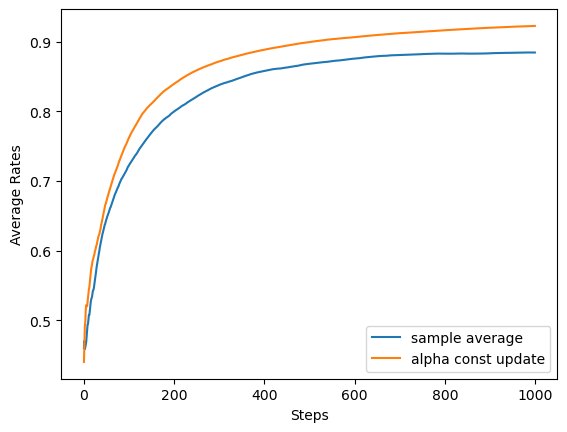

In [31]:
runs = 200
steps = 1000
epsilon = 0.1
alpha = 0.8
agent_types = ['sample average', 'alpha const update']
results = {}

for agent_type in agent_types:
    all_rates = np.zeros((runs, steps))  # (200, 1000)

    for run in range(runs):
        if agent_type == 'sample average':
            agent = Agent(epsilon)
        else:
            agent = AlphaAgent(epsilon, alpha)

        bandit = NonStatBandit()
        total_reward = 0
        rates = []

        for step in range(steps):
            action = agent.get_action()
            reward = bandit.play(action)
            agent.update(action, reward)
            total_reward += reward
            rates.append(total_reward / (step + 1))

        all_rates[run] = rates

    avg_rates = np.average(all_rates, axis=0)
    results[agent_type] = avg_rates

# plot
plt.figure()
plt.ylabel('Average Rates')
plt.xlabel('Steps')
for key, avg_rates in results.items():
    plt.plot(avg_rates, label=key)
plt.legend()
plt.show()